# Programming for Data Analysis - Project


## Abstract


In this project, you will investigate and explain box plots and their uses.

In your notebook, you should:
• Summarise the history of the box plot and situations in which it used.
• Demonstrate the use of the box plot using data of your choosing.
• Explain any relevant terminology such as the terms quartile and percentile.
• Compare the box plot to alternatives.



This Jupyter Python notebook explores a publicly-available dataset originating from the biennial Critical Assessment of protein Structure Prediction (CASP) competition, series 5-9. After first performing exploratory data analysis on the dataset, different tools are used to create a synthetic dataset *via* different Python libraries. For the synthesis, random numbers was generated following the distribution of each attribute. Lastly, a comparison is made between the original and the synthetic dataset to evaluate the accurary of the entire data synthesis process.

refs:
Mukhopadhyay_revised.pdf (desktop)
http://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure
https://en.wikipedia.org/wiki/CASP
Dataflow Acceleration of scikit-learn Gaussian Process Regression (desktop)


## Table of Contents

1. [Introduction](#introduction)
1. [Exploratory Data Analysis (EDA)](#eda)
1. [Methods for Data Synthesis / Simulation](#methodsForSimulation)
1. [Generation of a synthetic dataset](#generationOfSyntheticDataset)
1. [RMSD](#RMSD)
1. [Total Surface Area](#TotalArea)
1. [Discussion](#discussion)
1. [Conclusion](#conclusion)


## <a id='introduction'></a>Introduction - History of Box Plot and Its Uses


• Compare the box plot to alternatives.

Prior to performing more computationally-expensive analysis such as machine learning, it is important to visually and numerically explore the dataset in question. There are several approaches that can be taken - boxplots / violin plots, correlation matrices... - these are not mutually exclusive and can be achieved by simple commands. These approaches can be further augmented by interactive plots, enabled by Plotly and Bokeh libraries.

Boxplots are ...

Al

image: http://pbpython.com/python-vis-flowchart.html

Note: in this notebook, the road dataset (xxxxx) will be used. The focus here is on generating...


In order to not reinvent the wheel, we will use pre-existing Python libraries to achieve our goal.

A data frame with the annual deaths in road accidents for half the US states.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import pandas as pd
import seaborn as sns

# to make interactive plots with plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly import tools

# https://pypi.org/project/fitter/
# original fitter is here:
# but we use https://github.com/caiostringari/fitter/tree/master
# (to install: pip install --upgrade https://github.com/caiostringari/fitter/tarball/master)
from fitter import Fitter

from pylab import *

# to make plotly images - https://plot.ly/python/static-image-export/
import plotly.io as pio
from IPython.display import Image
# https://community.plot.ly/t/use-plotly-offline-to-save-chart-as-image-file/408/41
pio.orca.config.port = 80 # in case firewall blocks access to the default port of 39167

## <a id='eda'></a>Exploratory Data Analysis (EDA)
We will first look at the data structure and make modifications as required.

In [24]:
df = pd.read_csv('road.csv') # https://vincentarelbundock.github.io/Rdatasets/datasets.html
df # check to ensure reading csv file worked

,Unnamed: 0,deaths,drivers,popden,rural,temp,fuel
0,Alabama,968,158,64.0,66.0,62,119.0
1,Alaska,43,11,0.4,5.9,30,6.2
2,Arizona,588,91,12.0,33.0,64,65.0
3,Arkanas,640,92,34.0,73.0,51,74.0
4,Calif,4743,952,100.0,118.0,65,105.0
5,Colo,566,109,17.0,73.0,42,78.0
6,Conn,325,167,518.0,5.1,37,95.0
7,Dela,118,30,226.0,3.4,41,20.0
8,DC,115,35,12524.0,0.0,44,23.0
9,Florida,1545,298,91.0,57.0,67,216.0


From above, we can determine that we have 7 columns, with the first being a character/text column and the rest are numeric. 

For some reason, the first column, which looks like the states in the United States of America, is not labelled. The other column headers are not really descriptive, so we will rename these first.

In [25]:
# rename columns based on information from the source webpage (not all needs renaming)
# Columns are:
# 
# state
# deaths - number of deaths.
# drivers - number of drivers (in 10,000s).
# popden - population density in people per square mile.
# rural - length of rural roads, in 1000s of miles.
# temp - average daily maximum temperature in January.
# fuel - fuel consumption in 10,000,000 US gallons per year.

df.rename(columns={'Unnamed: 0': 'State',
                   'deaths': 'Deaths',
                   'drivers': 'Number of drivers (10,000)',
                   'popden': 'Population density (people/mile**2)',
                   'rural': 'Length of rural roads (1000 miles)',
                   'temp': 'Average daily max temperature in Jan',
                   'fuel': 'Fuel consumption (10**7 US gal/year)'
                  }, inplace = True)

Looking at the State column, we can see a mixture of full and abbreviated state names. As not everyone is familiar with the abbreviations, these states will also be renamed. For example, Miss could be interpreted as either Mississippi or Missouri. Fortunately, standardized abbreviations are [available](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations).

In [28]:
# https://stackoverflow.com/questions/44218091/
df.loc[df['State'] == 'Calif', 'State'] = 'California'
df.loc[df['State'] == 'Colo', 'State'] = 'Colorado'
df.loc[df['State'] == 'Conn', 'State'] = 'Connecticut'

df.loc[df['State'] == 'Dela', 'State'] = 'Delaware'
df.loc[df['State'] == 'DC', 'State'] = 'Washington DC'
df.loc[df['State'] == 'Ill', 'State'] = 'Illinois'
df.loc[df['State'] == 'Ind', 'State'] = 'Indiana'
df.loc[df['State'] == 'Kent', 'State'] = 'Kentucky'

df.loc[df['State'] == 'Louis', 'State'] = 'Louisiana'
df.loc[df['State'] == 'Maryl', 'State'] = 'Maryland'
df.loc[df['State'] == 'Mass', 'State'] = 'Massachusetts'

df.loc[df['State'] == 'Mich', 'State'] = 'Michigan'
df.loc[df['State'] == 'Minn', 'State'] = 'Minnesota'
df.loc[df['State'] == 'Miss', 'State'] = 'Mississippi'
df.loc[df['State'] == 'Mo', 'State'] = 'Missouri'
df.loc[df['State'] == 'Mont', 'State'] = 'Montana'

In [29]:
df

,State,Deaths,"Number of drivers (10,000)",Population density (people/mile**2),Length of rural roads (1000 miles),Average daily max temperature in Jan,Fuel consumption (10**7 US gal/year)
0,Alabama,968,158,64.0,66.0,62,119.0
1,Alaska,43,11,0.4,5.9,30,6.2
2,Arizona,588,91,12.0,33.0,64,65.0
3,Arkanas,640,92,34.0,73.0,51,74.0
4,California,4743,952,100.0,118.0,65,105.0
5,Colorado,566,109,17.0,73.0,42,78.0
6,Connecticut,325,167,518.0,5.1,37,95.0
7,Delaware,118,30,226.0,3.4,41,20.0
8,Washington DC,115,35,12524.0,0.0,44,23.0
9,Florida,1545,298,91.0,57.0,67,216.0


In [30]:
df.describe()

,Deaths,"Number of drivers (10,000)",Population density (people/mile**2),Length of rural roads (1000 miles),Average daily max temperature in Jan,Fuel consumption (10**7 US gal/year)
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,1000.653846,191.192308,595.734615,60.707692,43.692308,115.238462
std,946.842371,196.878037,2437.947300,38.378827,13.013129,83.857251
min,43.000000,11.000000,0.400000,0.000000,22.000000,6.200000
25%,571.500000,86.500000,31.750000,30.000000,33.750000,67.250000
50%,799.500000,148.500000,66.000000,65.500000,41.500000,104.500000
75%,1265.750000,226.250000,135.000000,93.500000,53.250000,154.500000
max,4743.000000,952.000000,12524.000000,124.000000,67.000000,350.000000


As we can see above, the column labels are more descriptive. Because the dataset is quite small, no memory optimization/downcast operations are needed.

We can now start a simple box plot.

In [34]:
trace1 = go.Box(y=df.iloc[:,1], marker = dict(size=3), text = df['State'])
trace2 = go.Box(y=df.iloc[:,2], marker = dict(size=3), text = df['State'])
trace3 = go.Box(y=df.iloc[:,3], marker = dict(size=3), text = df['State'])
trace4 = go.Box(y=df.iloc[:,4], marker = dict(size=3), text = df['State'])
trace5 = go.Box(y=df.iloc[:,5], marker = dict(size=3), text = df['State'])
trace6 = go.Box(y=df.iloc[:,6], marker = dict(size=3), text = df['State'])

# we have to make subplots because the scales are different for the variables
fig = tools.make_subplots(rows=2, cols=3, print_grid=False,
                          subplot_titles= (df.columns[1], df.columns[2], df.columns[3],
                                           df.columns[4], df.columns[5], df.columns[6]
                                                          ))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=800, width=800, title='<b>Figure 1: Box Plot of Road Accidents dataset</b>')
fig['layout'].update(showlegend=False)

# https://github.com/plotly/plotly.py/issues/985
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

for prop in fig.layout:
    if prop.startswith('xaxis'):
        # don't really need both xaxis label and subplot title, so turn xaxis label off
        fig.layout[prop].showticklabels = False

        
iplot(fig)

Figure 1 shows that for most of the variables, there is at least one outlier in each. Interestingly, however, the length of rural roads and the average daily max temperature in January are evenly spread (probably normally distributed).

From this, we can make the following observations:
1. The state of California has an extremely high number of deaths compared to the other states
1. There are significantly more drivers in California and Illinois than the other states, which could partially explain the higher number of deaths
1. Washington, DC, which is a federal district and the capital of the US, has a significantly high population density. This is probably caused by the small land area with a concentration of foreign diplomats living in the capital.
1. The fuel consumption in Illinois is at the higher extreme end for unknown reasons.

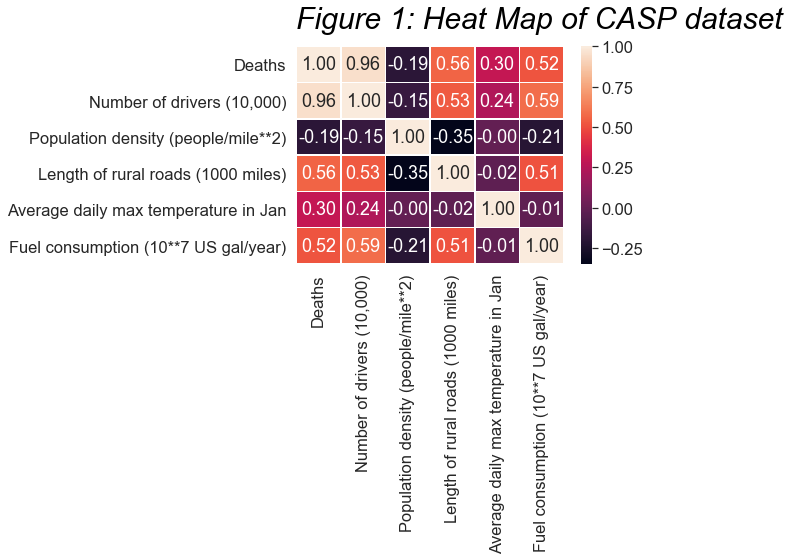

In [36]:
sns.set(font_scale=1.5)
# plt.figure(figsize=(15,15)) 
plt.text(0,-0.5, "Figure 1: Heat Map of CASP dataset", fontsize = 30, color='Black', fontstyle='italic')
# plt.tight_layout()

# according to the docs https://seaborn.pydata.org/generated/seaborn.heatmap.html and
# http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/
# we can use linewidths to create some spacing between the cells and
# fmt (format) to round 2 decimal points

# https://stackoverflow.com/questions/25790062/
sns.heatmap(df.corr(), annot=True, linewidths = 0.5, fmt='.2f');

We can make the following observations:

1. RMSD is poorly correlated with any of the other variables.
1. There is a strong positive correlation between Total surface area and non-polar exposed area, Fractional area of exposed non-polar part of residue, Molecular mass weighted exposed area, Average deviation from standard exposed area of residue, and strong negative correlation with spatial distribution constraints.
1. With the exception of RMSD and Fractional area of exposed non-polar residue, all variables have strong correlation with the spatial distribution constraints.

Based on the variable labels and the correlation coefficients above, it seems likely that some variables could be collinear, rather than truly correlated. A multivariate analysis using the `pairplot()` function can shed some light here.

In [37]:
# https://community.plot.ly/t/splom-scatter-matrix-changing-styles-of-all-axes-in-one-go/16636/2
# https://plot.ly/python/splom/

# initiate placeholders
dataPanda = []
label = ''

for column in list(df.columns):
        
    columnSplit = column.split(' ') # create a list of string from the column name
    
    for i in columnSplit:
        label = label + i + '<br>' # because plotly uses JavaScript, we can use the html <br> tag to split to next line
    
    # inspired by: https://stackoverflow.com/questions/43229013/
    for i in range(3):
        label = '<br>' + label + '<br>'
    
    label = '<i>' + label + '</i>'
    trace = dict(label = label, values = df[column])
    
    dataPanda.append(trace)
    label = '' # reset the variable for next for iteration

trace1 = go.Splom(dimensions=dataPanda, showupperhalf=False, marker=dict(size=3, color='green'))
data = [trace1]


layout = go.Layout(title = '<b>Figure 2: Scatterplot Matrix of CASP dataset</b>',
                font=dict(size=8.5), # global font
                titlefont=dict(size=20), # but we want only title to have different size
                margin = dict(l = 150, r = 20, b = 150) # layout control- left, right, bottom, top (t) and padding (pad )
                )           
    
fig = go.Figure(data=data, layout=layout)
fig['layout'].update(height=800, width=900)

iplot(fig)

### Explanation of statistical terms

#### quartile and percentile.

***

## <a id='methodsForSimulation'></a>Methods for Data Synthesis / Simulation

In any case, we should look at the distribution of each variable. Scipy comes with many well-known distributions PDF, which each function takes usually two parameters - scale to control xx and loc to control mean.

While we could manually fit each distribution for each variable, we can use the `fitter` module to automatically generate the curves for us. In essence, `fitter` uses Scipy curve_fit to do xx and yy...

In essence, a synthetic dataset can be generated by the following methods:

1. For dataset related to a specific chemical or physical phenomenon, the relationship between the response and predictor variables can often be described as a mathematical equation (first principles and/or mechanistic model). Usually, the model takes the form of a differential equation. In this case, an error term referencing random numbers (noise) can be added to that model to yield a synthetic dataset.
1. For those that do not have a mathematical equation defined in the literature but follows a well-described and widely used distribution, we can use one of the [35+ `numpy.random` functions](https://docs.scipy.org/doc/numpy/reference/routines.random.html), for example `numpy.random.beta()`. Alternatively, a larger set of functions from [`scipy.stats` (about 80 functions)](http://scipy.github.io/devdocs/stats.html) can be used, for example `scipy.stats.rvs()`.

    However, we need to know the parameters, such as $\mu$ and $\sigma$ for the mean and standard deviation for a normal distribution, respectively, . This can be estimated by 'eye', trial-and-error or automated/manual curve fitting. In this project, the [Fitter package](https://pythonhosted.org/fitter/) will be used. Fitter is essentially a wrapper module around  `scipy.stats` as the probability distribution source and `scipy.optimize.curve_fit()` for non-linear least squares curve fitting, which can rapidly achieve convergence given initial parameter estimates that roughly match the actual parameter values for the corresponding probability distribution function (PDF). 
    
    Note that the [original GitHub repository for this package](https://github.com/cokelaer/fitter) was last updated about 2 years. Therefore, a [different branch](https://github.com/caiostringari/fitter/tree/master) with more recent updates aligned to the latest Matplotlib library will be used. For installation, use the following command in shell: `pip install --upgrade https://github.com/caiostringari/fitter/tarball/master` (`--upgrade` can be omitted if installing for the first time). 

    Simulating a dataset following a bimodal normal distribution is difficult with `numpy.random` but [doable](https://stackoverflow.com/questions/4265988/generate-random-numbers-with-a-given-numerical-distribution).

1. For these difficult cases where there are no well-known distributions, [inverse transform sampling (ITS)](http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/) can be employed.
    1. [Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling), in essence, is a method to rescale a uniform random variable (which is what numpy.random returns - see the Programming for Data Analysis Assignment) into a desired probability distribution.
    1. The cumulative distribution function (CDF) can be thought of as the integral of the data histogram [which itself is a (PDF)], giving us [the percentage or the relative count plotted against the data](https://www.andata.at/en/software-blog-reader/why-we-love-the-cdf-and-do-not-like-histograms-that-much.html). CDF has a $y$ axis of [0,1].
    1. Inverting the CDF allows the sampling of the uniform values because the y-axis is turned into an x-axis of [0,1], followed by a transformation into the target distribution.

### Alternatives to Box Plots

The most directly comparable alternative to box plot is the violin plot. Although rarely used, it is actually more informative than box plots but require some non-intuitive interpretation.

https://plot.ly/python/violin/

***

## <a id='generationOfSyntheticDataset'></a>Generation of a synthetic dataset

For clarity, each column will be synthesized using one or more standard Scipy distributions and ITS followed by a graphical distribution comparison to the original (experimental) data. In the end, these synthetic columns will be assembled as a Pandas dataframe and corresponding box plots and scatter matrices generated.

### <a id='RMSD'></a>RMSD
Let's fit the RMSD first

In [ ]:
RMSD_values = df['RMSD'] # get all RMSD values

f_RMSD = Fitter(RMSD_values)
f_RMSD.fit()

In [ ]:
f = Fitter(df['Average deviation from standard exposed area of residue'], bins=200)
f.fit()

In [ ]:
f.summary()

From the Fitter summary above, exponentially-modified normal distribution provides a good description of the data. As such, we can use the automatic fitting parameters to generate random values and compared with ITS and the experimental data.

Note: for some reason, probably due to the extreme values (tail) that are not captured by both exponnorm and ITS, we will only generate 20000 values to generate synthetic data matching the experimental one.

With the exception of a shoulder at around $x = 250$ and extreme values at the higher end of $x$, both ITS and the exponentially-modified normal distribution capture the full experimental data.
***
### <a id='EuclidianDistance'></a> Euclidian distance

Euclidian distance is ...

From the comparative box plot above, the following can be noted:
1. both ITS and several of the standard probability distributions can be used to synthesize datasets that have similar characteristics as the experimental dataset
1. ITS provides a method for a more accurate data simulation compared to the standard distributions, due to simplified parametrization leading to constrained fitting of the experimental data to fit the model. This is especially so for the Euclidian distance variable where outliers were generated by the standard distribution method.

***
## <a id='conclusion'></a>Conclusion

Experimental dataset are valuable as they capture the nuances of the system under study. However, in many instances, it is not possible to obtain a large number of datapoints, especially when it involves long duration or high expenses. For those situations, it would be useful to generate a set of random values that resemble the experimental data. By having a combined 'experimental + synthetic' dataset, we can gain the ability to train machine learning algorithms, where highly-variant large datasets is a pre-requisite.

Similarly, the use of synthetic datasets helps in the case of parameter estimation for complex (highly parametrized) mechanistic models. Bayesian techniques such as Markov chain Monte Carlo (MCMC) simulations can be performed from a simulated dataset following a verification on the experimental dataset.

Through this notebook, we have learned how the CASP dataset is organized and the different abilities of `numpy.random` and `scipy.stats` libraries as well as their augmentation by inverse transform sampling.